# Klasifikasi Sentimen Ujaran Kebencian Terhadap Agama Islam Pada Platform Twitter Menggunakan Multinomial Naive Bayes

Proyek ini dibuat oleh
- Nama: Zul Iflah Al Juhaeda
- NIM: 200605110139

## 1. Setup dan Konfigurasi

Pada langkah ini, kita akan melakukan instalasi dan import library yang diperlukan, mengatur seed untuk memastikan reproducibility, mengonfigurasi logging untuk mencatat proses, serta membuat struktur direktori yang akan digunakan untuk menyimpan berbagai file hasil proyek.

In [1]:
# ### Instalasi Library
# Jika Anda belum menginstal library yang diperlukan, Anda dapat menguncomment dan menjalankan baris berikut:
# !pip install pandas numpy scikit-learn matplotlib seaborn nltk

# ### Import Library
import os
import pandas as pd
import numpy as np
import random
import logging
import re
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords

# ### Konfigurasi Seed
np.random.seed(42)
random.seed(42)

# ### Konfigurasi Logging
logging.basicConfig(
    filename='C:\\SkripsiFix\\2. Code\\Model\\process_log.log',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    filemode='a'
)
logger = logging.getLogger()

logger.info('Setup dan konfigurasi awal telah dilakukan.')

# ### Pembuatan Struktur Direktori
directories = [
    'C:\\SkripsiFix\\2. Code\\Model\\csv\\',
    'C:\\SkripsiFix\\2. Code\\Model\\pickle\\',
    'C:\\SkripsiFix\\2. Code\\Model\\png\\'
]

for directory in directories:
    try:
        os.makedirs(directory, exist_ok=True)
        logger.info(f'Direktori "{directory}" telah dibuat atau sudah ada.')
    except Exception as e:
        logger.error(f'Gagal membuat direktori "{directory}". Error: {e}')

logger.info('Struktur direktori telah siap.')


## 2. Eksplorasi Data
Deskripsi Singkat Langkah Ini
Pada langkah ini, kita akan memuat dataset yang berisi tweet dari Umat Muslim di Indonesia, melakukan validasi awal terhadap data tersebut, menampilkan beberapa baris pertama untuk memahami struktur data, serta membersihkan data dari duplikasi. Hasil pembersihan data akan disimpan dalam format CSV dan pickle untuk digunakan pada langkah selanjutnya. Seluruh proses akan dicatat menggunakan logging untuk memudahkan pelacakan.

In [2]:
# ### Import Library Tambahan
import pandas as pd

# ### Memuat Dataset
dataset_path = 'C:\\SkripsiFix\\2. Code\\Model\\dataset.xlsx'

try:
    df = pd.read_excel(dataset_path)
    logger.info(f'Dataset berhasil dimuat dari "{dataset_path}".')
    logger.info(f'Dataset memiliki {df.shape[0]} baris dan {df.shape[1]} kolom.')
    print(f'Dataset berhasil dimuat dengan {df.shape[0]} baris dan {df.shape[1]} kolom.')
except FileNotFoundError:
    logger.error(f'File "{dataset_path}" tidak ditemukan.')
    print(f'Error: File "{dataset_path}" tidak ditemukan.')
except Exception as e:
    logger.error(f'Gagal memuat dataset. Error: {e}')
    print(f'Error saat memuat dataset: {e}')

# ### Menampilkan Head Data
print("Beberapa baris pertama dari dataset:")
display(df.head())

# ### Menghapus Duplikasi
initial_shape = df.shape
df_cleaned = df.drop_duplicates()
final_shape = df_cleaned.shape

if initial_shape != final_shape:
    logger.info(f'Duplikasi dihapus. Ukuran dataset awal: {initial_shape[0]} baris, setelah penghapusan: {final_shape[0]} baris.')
    print(f'Duplikasi dihapus. Ukuran dataset awal: {initial_shape[0]} baris, setelah penghapusan: {final_shape[0]} baris.')
else:
    logger.info('Tidak ditemukan duplikasi dalam dataset.')
    print('Tidak ditemukan duplikasi dalam dataset.')

# ### Menyimpan Data yang Telah Dibersihkan
cleaned_csv_path = 'C:\\SkripsiFix\\2. Code\\Model\\csv\\cleaned_data.csv'
cleaned_pickle_path = 'C:\\SkripsiFix\\2. Code\\Model\\pickle\\cleaned_data.pkl'

try:
    df_cleaned.to_csv(cleaned_csv_path, index=False)
    df_cleaned.to_pickle(cleaned_pickle_path)
    logger.info(f'Data yang telah dibersihkan disimpan sebagai CSV di "{cleaned_csv_path}" dan sebagai pickle di "{cleaned_pickle_path}".')
    print(f'Data yang telah dibersihkan disimpan sebagai CSV di "{cleaned_csv_path}" dan sebagai pickle di "{cleaned_pickle_path}".')
except Exception as e:
    logger.error(f'Gagal menyimpan data yang telah dibersihkan. Error: {e}')
    print(f'Error saat menyimpan data yang telah dibersihkan: {e}')


Dataset berhasil dimuat dengan 1200 baris dan 2 kolom.
Beberapa baris pertama dari dataset:


,full_text,kelas
0,@Buahterlar42596 @aprimayoga19 Jancuk'an Wong ...,Negatif
1,Eng Ing Eeeeng ... Semoga para biadab yg mempe...,Positif
2,@suleizdn @umarfaruqi_SHI @Generasi_MudaNU orm...,Negatif
3,@denismalhotra Mreka kan kturunan yahudi pesek...,Negatif
4,@bctnakal @_faktaindo ajaran islam memang biad...,Negatif


Duplikasi dihapus. Ukuran dataset awal: 1200 baris, setelah penghapusan: 1191 baris.
Data yang telah dibersihkan disimpan sebagai CSV di "C:\SkripsiFix\2. Code\Model\csv\cleaned_data.csv" dan sebagai pickle di "C:\SkripsiFix\2. Code\Model\pickle\cleaned_data.pkl".


## 3. Preprocessing Data
Deskripsi Singkat Langkah Ini
Pada langkah ini, kita akan melakukan preprocessing pada teks tweet yang mencakup pembersihan teks, konversi ke huruf kecil, tokenisasi, penghapusan stopword, stemming, dan penggabungan kembali teks yang telah diproses. Proses ini akan dimodularisasi dengan membuat file preprocessing.py yang berisi fungsi-fungsi preprocessing yang dapat diimpor dan digunakan dalam notebook. Hasil akhir dari preprocessing akan ditampilkan dalam bentuk tabel yang menunjukkan tahapan pemrosesan pada lima data awal.

In [3]:
# ### Import Modul Preprocessing
import sys
import pandas as pd

# Menambahkan direktori dimana preprocessing.py berada ke path sistem
sys.path.append('C:\\SkripsiFix\\2. Code\\Model\\')

from preprocessing import preprocess_text

# ### Memuat Data yang Telah Dibersihkan
cleaned_csv_path = 'C:\\SkripsiFix\\2. Code\\Model\\csv\\cleaned_data.csv'

try:
    df_cleaned = pd.read_csv(cleaned_csv_path)
    logger.info(f'Data yang telah dibersihkan berhasil dimuat dari "{cleaned_csv_path}".')
    print(f'Data yang telah dibersihkan berhasil dimuat dengan {df_cleaned.shape[0]} baris dan {df_cleaned.shape[1]} kolom.')
except FileNotFoundError:
    logger.error(f'File "{cleaned_csv_path}" tidak ditemukan.')
    print(f'Error: File "{cleaned_csv_path}" tidak ditemukan.')
except Exception as e:
    logger.error(f'Gagal memuat data yang telah dibersihkan. Error: {e}')
    print(f'Error saat memuat data yang telah dibersihkan: {e}')

# ### Menambahkan Kolom Hasil Preprocessing
preprocessing_results = df_cleaned['full_text'].apply(preprocess_text)

df_cleaned[['cleaned_text', 'lower_text', 'tokens', 'no_stopwords', 'stemmed_tokens', 'processed_text']] = pd.DataFrame(preprocessing_results.tolist(), index=df_cleaned.index)

# ### Menampilkan Tabel Preprocessing
display(df_cleaned[['full_text', 'cleaned_text', 'lower_text', 'tokens', 'no_stopwords', 'stemmed_tokens', 'processed_text']].head(5))

# ### Menyimpan Hasil Preprocessing
preprocessed_csv_path = 'C:\\SkripsiFix\\2. Code\\Model\\csv\\preprocessed_data.csv'
preprocessed_pickle_path = 'C:\\SkripsiFix\\2. Code\\Model\\pickle\\preprocessed_data.pkl'

try:
    df_cleaned.to_csv(preprocessed_csv_path, index=False)
    df_cleaned.to_pickle(preprocessed_pickle_path)
    logger.info(f'Hasil preprocessing disimpan ke "{preprocessed_csv_path}" dan "{preprocessed_pickle_path}".')
    print(f'Hasil preprocessing disimpan ke "{preprocessed_csv_path}" dan "{preprocessed_pickle_path}".')
except Exception as e:
    logger.error(f'Gagal menyimpan hasil preprocessing. Error: {e}')
    print(f'Error saat menyimpan hasil preprocessing: {e}')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aljuh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Data yang telah dibersihkan berhasil dimuat dengan 1191 baris dan 2 kolom.


,full_text,cleaned_text,lower_text,tokens,no_stopwords,stemmed_tokens,processed_text
0,@Buahterlar42596 @aprimayoga19 Jancuk'an Wong ...,Jancukan Wong iki sopo seng Biadab Awakmu ...,jancukan wong iki sopo seng biadab awakmu ...,"[jancukan, wong, iki, sopo, seng, biadab, awak...","[jancukan, iki, sopo, seng, biadab, awakmu, ta...","[jancukan, iki, sopo, seng, biadab, awakmu, ta...",jancukan iki sopo seng biadab awakmu ta ummat ...
1,Eng Ing Eeeeng ... Semoga para biadab yg mempe...,Eng Ing Eeeeng Semoga para biadab yg memperma...,eng ing eeeeng semoga para biadab yg memperma...,"[eng, ing, eeeeng, semoga, para, biadab, yg, m...","[eng, ing, eeeeng, semoga, biadab, yg, memperm...","[eng, ing, eeeeng, semoga, biadab, yg, memperm...",eng ing eeeeng semoga biadab yg mempermainkan ...
2,@suleizdn @umarfaruqi_SHI @Generasi_MudaNU orm...,ormas ini anggap umat Islam dan ormas Islam...,ormas ini anggap umat islam dan ormas islam...,"[ormas, ini, anggap, umat, islam, dan, ormas, ...","[ormas, anggap, umat, islam, ormas, islam, mus...","[orma, anggap, umat, islam, orma, islam, musuh...",orma anggap umat islam orma islam musuhnya dun...
3,@denismalhotra Mreka kan kturunan yahudi pesek...,Mreka kan kturunan yahudi pesek bang Islam kt...,mreka kan kturunan yahudi pesek bang islam kt...,"[mreka, kan, kturunan, yahudi, pesek, bang, is...","[mreka, kturunan, yahudi, pesek, bang, islam, ...","[mreka, kturunan, yahudi, pesek, bang, islam, ...",mreka kturunan yahudi pesek bang islam ktp mre...
4,@bctnakal @_faktaindo ajaran islam memang biad...,ajaran islam memang biadab orang kemalangan ...,ajaran islam memang biadab orang kemalangan ...,"[ajaran, islam, memang, biadab, orang, kemalan...","[ajaran, islam, biadab, orang, kemalangan, men...","[ajaran, islam, biadab, orang, kemalangan, men...",ajaran islam biadab orang kemalangan menghujat...


Hasil preprocessing disimpan ke "C:\SkripsiFix\2. Code\Model\csv\preprocessed_data.csv" dan "C:\SkripsiFix\2. Code\Model\pickle\preprocessed_data.pkl".


## 4. Pembagian Data (Data Splitting)
Deskripsi Singkat Langkah Ini
Pada langkah ini, kita akan membagi dataset yang telah dipreproses menjadi set pelatihan (training set) dan set pengujian (testing set) dengan berbagai rasio pembagian: 70:30, 80:20, dan 90:10. Pembagian ini akan dilakukan menggunakan stratified split untuk memastikan bahwa distribusi kelas (positif dan negatif) tetap seimbang di setiap split. Setelah pembagian, kita akan memvalidasi distribusi kelas di setiap split dan menyimpan hasil pembagian data dalam format CSV dan pickle. Seluruh proses akan dicatat menggunakan logging untuk memudahkan pelacakan.

In [4]:
# ### Import Library Tambahan
from sklearn.model_selection import train_test_split

# ### Memuat Data yang Telah Dipreproses
preprocessed_csv_path = 'C:\\SkripsiFix\\2. Code\\Model\\csv\\preprocessed_data.csv'

try:
    df_preprocessed = pd.read_csv(preprocessed_csv_path)
    logger.info(f'Data yang telah dipreproses berhasil dimuat dari "{preprocessed_csv_path}".')
    print(f'Data yang telah dipreproses berhasil dimuat dengan {df_preprocessed.shape[0]} baris dan {df_preprocessed.shape[1]} kolom.')
except FileNotFoundError:
    logger.error(f'File "{preprocessed_csv_path}" tidak ditemukan.')
    print(f'Error: File "{preprocessed_csv_path}" tidak ditemukan.')
except Exception as e:
    logger.error(f'Gagal memuat data yang telah dipreproses. Error: {e}')
    print(f'Error saat memuat data yang telah dipreproses: {e}')

# ### Mendefinisikan Fungsi untuk Membagi Data
def split_data(df, test_size, random_state=42):
    """
    Membagi data menjadi training dan testing set dengan stratified split.
    
    Parameters:
    - df: DataFrame, dataset yang akan dibagi.
    - test_size: float, proporsi data untuk testing set.
    - random_state: int, seed untuk reproducibility.
    
    Returns:
    - X_train, X_test, y_train, y_test: hasil pembagian data.
    """
    X = df['processed_text']
    y = df['kelas']
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        stratify=y,
        random_state=random_state
    )
    
    return X_train, X_test, y_train, y_test

# ### Mendefinisikan Rasio Pembagian yang Diinginkan
split_ratios = {
    '70_30': 0.3,
    '80_20': 0.2,
    '90_10': 0.1
}

# ### Melakukan Pembagian Data untuk Setiap Rasio
for ratio_name, test_size in split_ratios.items():
    try:
        X_train, X_test, y_train, y_test = split_data(df_preprocessed, test_size=test_size)
        
        # Membuat DataFrame untuk Training dan Testing Set
        train_df = pd.DataFrame({
            'processed_text': X_train,
            'kelas': y_train
        })
        
        test_df = pd.DataFrame({
            'processed_text': X_test,
            'kelas': y_test
        })
        
        # Menyimpan Training Set
        train_csv_path = f'C:\\SkripsiFix\\2. Code\\Model\\csv\\train_{ratio_name}.csv'
        train_pickle_path = f'C:\\SkripsiFix\\2. Code\\Model\\pickle\\train_{ratio_name}.pkl'
        
        train_df.to_csv(train_csv_path, index=False)
        train_df.to_pickle(train_pickle_path)
        
        # Menyimpan Testing Set
        test_csv_path = f'C:\\SkripsiFix\\2. Code\\Model\\csv\\test_{ratio_name}.csv'
        test_pickle_path = f'C:\\SkripsiFix\\2. Code\\Model\\pickle\\test_{ratio_name}.pkl'
        
        test_df.to_csv(test_csv_path, index=False)
        test_df.to_pickle(test_pickle_path)
        
        logger.info(f'Data dibagi dengan rasio {ratio_name} dan disimpan sebagai CSV dan pickle.')
        print(f'Data dibagi dengan rasio {ratio_name} dan disimpan sebagai CSV dan pickle.')
        
        # ### Validasi Distribusi Kelas
        train_class_dist = train_df['kelas'].value_counts(normalize=True)
        test_class_dist = test_df['kelas'].value_counts(normalize=True)
        
        logger.info(f'Distribusi kelas pada training set ({ratio_name}):\n{train_class_dist}')
        logger.info(f'Distribusi kelas pada testing set ({ratio_name}):\n{test_class_dist}')
        
        print(f'Distribusi kelas pada training set ({ratio_name}):\n{train_class_dist}')
        print(f'Distribusi kelas pada testing set ({ratio_name}):\n{test_class_dist}')
        
    except Exception as e:
        logger.error(f'Gagal membagi data dengan rasio {ratio_name}. Error: {e}')
        print(f'Error saat membagi data dengan rasio {ratio_name}: {e}')


Data yang telah dipreproses berhasil dimuat dengan 1191 baris dan 8 kolom.
Data dibagi dengan rasio 70_30 dan disimpan sebagai CSV dan pickle.
Distribusi kelas pada training set (70_30):
kelas
Negatif    0.835534
Positif    0.164466
Name: proportion, dtype: float64
Distribusi kelas pada testing set (70_30):
kelas
Negatif    0.835196
Positif    0.164804
Name: proportion, dtype: float64
Data dibagi dengan rasio 80_20 dan disimpan sebagai CSV dan pickle.
Distribusi kelas pada training set (80_20):
kelas
Negatif    0.835084
Positif    0.164916
Name: proportion, dtype: float64
Distribusi kelas pada testing set (80_20):
kelas
Negatif    0.83682
Positif    0.16318
Name: proportion, dtype: float64
Data dibagi dengan rasio 90_10 dan disimpan sebagai CSV dan pickle.
Distribusi kelas pada training set (90_10):
kelas
Negatif    0.835668
Positif    0.164332
Name: proportion, dtype: float64
Distribusi kelas pada testing set (90_10):
kelas
Negatif    0.833333
Positif    0.166667
Name: proportion, dty

## 5. Bag Of Words
Pada langkah ini, kita akan mengubah data teks yang telah dipreproses menjadi representasi numerik menggunakan metode Bag of Words (BoW) dengan CountVectorizer dari scikit-learn. Proses ini akan dimodularisasi dengan membuat file bow.py yang berisi fungsi-fungsi untuk melakukan ekstraksi fitur. Objek CountVectorizer yang telah dilatih akan disimpan untuk digunakan kembali di masa mendatang. Hasil ekstraksi fitur untuk setiap rasio pembagian data akan disimpan dalam format Pickle untuk efisiensi penyimpanan dan penggunaan.

In [5]:
# ### Import Modul Bag of Words
import sys
import pandas as pd
from bow import train_vectorizer, transform_texts, save_vectorizer, save_bow

# Menambahkan direktori dimana bow.py berada ke path sistem
sys.path.append('C:\\SkripsiFix\\2. Code\\Model\\')

# ### Mendefinisikan Rasio Pembagian yang Diinginkan
split_ratios = ['70_30', '80_20', '90_10']

csv_dir = 'C:\\SkripsiFix\\2. Code\\Model\\csv\\'
pickle_dir = 'C:\\SkripsiFix\\2. Code\\Model\\pickle\\'

# ### Mengumpulkan Semua Teks Pelatihan dari Semua Split Rasio
all_train_texts = []
for ratio in split_ratios:
    train_csv_path = f'{csv_dir}train_{ratio}.csv'
    try:
        train_df = pd.read_csv(train_csv_path)
        all_train_texts.extend(train_df['processed_text'].tolist())
        logger.info(f'Memuat training set untuk rasio {ratio} dari "{train_csv_path}".')
        print(f'Memuat training set untuk rasio {ratio} dari "{train_csv_path}".')
    except FileNotFoundError:
        logger.error(f'File training set untuk rasio {ratio} tidak ditemukan di "{train_csv_path}".')
        print(f'Error: File training set untuk rasio {ratio} tidak ditemukan.')
    except Exception as e:
        logger.error(f'Gagal memuat training set untuk rasio {ratio}. Error: {e}')
        print(f'Error saat memuat training set untuk rasio {ratio}: {e}')

# ### Melatih CountVectorizer pada Semua Teks Pelatihan
try:
    vectorizer = train_vectorizer(all_train_texts, max_features=1000)
    logger.info('CountVectorizer telah dilatih pada seluruh data pelatihan.')
    print('CountVectorizer telah dilatih pada seluruh data pelatihan.')
except Exception as e:
    logger.error(f'Gagal melatih CountVectorizer. Error: {e}')
    print(f'Error saat melatih CountVectorizer: {e}')

# ### Menyimpan CountVectorizer
try:
    save_vectorizer(vectorizer, pickle_dir)
    print('CountVectorizer telah disimpan.')
except Exception as e:
    logger.error(f'Gagal menyimpan CountVectorizer. Error: {e}')
    print(f'Error saat menyimpan CountVectorizer: {e}')

# ### Mengubah dan Menyimpan Matriks Bag of Words untuk Setiap Split Rasio
for ratio in split_ratios:
    try:
        # Memuat Training dan Testing Set untuk Rasio Tersebut
        train_csv_path = f'{csv_dir}train_{ratio}.csv'
        test_csv_path = f'{csv_dir}test_{ratio}.csv'
        
        train_df = pd.read_csv(train_csv_path)
        test_df = pd.read_csv(test_csv_path)
        
        logger.info(f'Memuat training dan testing set untuk rasio {ratio}.')
        print(f'Memuat training dan testing set untuk rasio {ratio}.')
        
        # Mengubah Teks menjadi Matriks Bag of Words
        X_train_bow = transform_texts(vectorizer, train_df['processed_text'].tolist())
        X_test_bow = transform_texts(vectorizer, test_df['processed_text'].tolist())
        
        logger.info(f'Ekstraksi fitur Bag of Words selesai untuk rasio {ratio}.')
        print(f'Ekstraksi fitur Bag of Words selesai untuk rasio {ratio}.')
        
        # Menyimpan Matriks Bag of Words
        save_bow(X_train_bow, ratio, pickle_dir, dataset_type='train')
        save_bow(X_test_bow, ratio, pickle_dir, dataset_type='test')
        
        print(f'Matriks Bag of Words untuk rasio {ratio} telah disimpan.')
        
        # ### Menampilkan Dimensi Matriks Fitur
        print(f'Dimensi matriks fitur Bag of Words untuk rasio {ratio}:')
        print(f' - Training set: {X_train_bow.shape}')
        print(f' - Testing set: {X_test_bow.shape}\n')
        
    except FileNotFoundError as fnf_error:
        logger.error(f'File tidak ditemukan untuk rasio {ratio}. Error: {fnf_error}')
        print(f'Error: File tidak ditemukan untuk rasio {ratio}.')
    except Exception as e:
        logger.error(f'Gagal melakukan Bag of Words untuk rasio {ratio}. Error: {e}')
        print(f'Error saat melakukan Bag of Words untuk rasio {ratio}: {e}')


Memuat training set untuk rasio 70_30 dari "C:\SkripsiFix\2. Code\Model\csv\train_70_30.csv".
Memuat training set untuk rasio 80_20 dari "C:\SkripsiFix\2. Code\Model\csv\train_80_20.csv".
Memuat training set untuk rasio 90_10 dari "C:\SkripsiFix\2. Code\Model\csv\train_90_10.csv".
CountVectorizer telah dilatih pada seluruh data pelatihan.
CountVectorizer telah disimpan.
Memuat training dan testing set untuk rasio 70_30.
Ekstraksi fitur Bag of Words selesai untuk rasio 70_30.
Matriks Bag of Words untuk rasio 70_30 telah disimpan.
Dimensi matriks fitur Bag of Words untuk rasio 70_30:
 - Training set: (833, 1000)
 - Testing set: (358, 1000)

Memuat training dan testing set untuk rasio 80_20.
Ekstraksi fitur Bag of Words selesai untuk rasio 80_20.
Matriks Bag of Words untuk rasio 80_20 telah disimpan.
Dimensi matriks fitur Bag of Words untuk rasio 80_20:
 - Training set: (952, 1000)
 - Testing set: (239, 1000)

Memuat training dan testing set untuk rasio 90_10.
Ekstraksi fitur Bag of Words

## 6. Multinomial Naive Bayes dengan Hyperparameter Tuning

In [6]:
import logging

# Mengatur konfigurasi logging
logging.basicConfig(
    filename='C:\\SkripsiFix\\2. Code\\Model\\process_log.log',
    level=logging.INFO,
    format='%(asctime)s %(levelname)s:%(message)s'
)


### 6.1 Tuning Minimal

In [7]:
# ### Import Modul Multinomial Naive Bayes
import sys
import pandas as pd
import pickle
from mnb import train_mnb, evaluate_model, save_model, save_evaluation

# Menambahkan direktori dimana mnb.py berada ke path sistem
sys.path.append('C:\\SkripsiFix\\2. Code\\Model\\')

# ### Mendefinisikan Rasio Pembagian yang Diinginkan
split_ratios = ['70_30', '80_20', '90_10']

csv_dir = 'C:\\SkripsiFix\\2. Code\\Model\\csv\\'
pickle_dir = 'C:\\SkripsiFix\\2. Code\\Model\\pickle\\'

# ### Mendefinisikan Konfigurasi Hyperparameter Tuning (Nilai Minimal)
tuning_type = 'minimal'
alphas = [0.01, 0.1, 1.0]

# ### Melakukan Pelatihan Model untuk Setiap Split dan Konfigurasi Tuning Minimal
for ratio in split_ratios:
    print(f"=== Multinomial Naive Bayes untuk Rasio Data {ratio} ===\n")
    
    best_alpha = None
    best_accuracy = 0
    best_report = None
    
    print(f"-- MNB dengan Hyperparameter Tuning (Nilai Minimal) untuk Rasio {ratio} --")
    
    for alpha in alphas:
        try:
            # Memuat Training dan Testing Set untuk Rasio Tersebut
            train_csv_path = f'{csv_dir}train_{ratio}.csv'
            test_csv_path = f'{csv_dir}test_{ratio}.csv'
            
            train_df = pd.read_csv(train_csv_path)
            test_df = pd.read_csv(test_csv_path)
            
            # Memuat Matriks Bag of Words dari Pickle
            train_bow_pkl = f'{pickle_dir}train_bow_{ratio}.pkl'
            test_bow_pkl = f'{pickle_dir}test_bow_{ratio}.pkl'
            
            with open(train_bow_pkl, 'rb') as f:
                X_train_bow = pickle.load(f)
            with open(test_bow_pkl, 'rb') as f:
                X_test_bow = pickle.load(f)
            
            # Melatih Model Multinomial Naive Bayes
            model = train_mnb(X_train_bow, train_df['kelas'], alpha=alpha)
            
            # Mengevaluasi Model
            accuracy, report = evaluate_model(model, X_test_bow, test_df['kelas'])
            
            # Menyimpan Model yang Telah Dilatih
            save_model(model, ratio, alpha, tuning_type, pickle_dir)
            
            # Menyimpan Hasil Evaluasi
            save_evaluation(accuracy, report, ratio, alpha, tuning_type, csv_dir)
            
            # Memeriksa apakah alpha ini memberikan akurasi terbaik
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_alpha = alpha
                best_report = report
            
            print(f" - Alpha {alpha}: Akurasi = {accuracy:.2f}")
        
        except FileNotFoundError as fnf_error:
            print(f'Error: File tidak ditemukan untuk rasio {ratio}. {fnf_error}')
        except Exception as e:
            print(f'Error saat melatih model MNB untuk rasio {ratio} dengan alpha={alpha}: {e}')
    
    if best_alpha is not None:
        print(f"\nModel terbaik dengan alpha: {best_alpha}\n")
        print(f"Laporan Klasifikasi (Alpha Minimal):")
        # Membuat laporan klasifikasi menjadi DataFrame
        report_df = pd.DataFrame(best_report).transpose().drop(columns=['support'])
        report_df = report_df.round(2)  # Membulatkan angka ke dua decimal
        print(report_df.to_string())
    else:
        print("Tidak ada model yang berhasil dilatih.\n")
    
    print("\n" + "-"*80 + "\n")


=== Multinomial Naive Bayes untuk Rasio Data 70_30 ===

-- MNB dengan Hyperparameter Tuning (Nilai Minimal) untuk Rasio 70_30 --
 - Alpha 0.01: Akurasi = 0.79
 - Alpha 0.1: Akurasi = 0.78
 - Alpha 1.0: Akurasi = 0.83

Model terbaik dengan alpha: 1.0

Laporan Klasifikasi (Alpha Minimal):
              precision  recall  f1-score
Negatif            0.87    0.93      0.90
Positif            0.46    0.32      0.38
accuracy           0.83    0.83      0.83
macro avg          0.67    0.62      0.64
weighted avg       0.81    0.83      0.81

--------------------------------------------------------------------------------

=== Multinomial Naive Bayes untuk Rasio Data 80_20 ===

-- MNB dengan Hyperparameter Tuning (Nilai Minimal) untuk Rasio 80_20 --
 - Alpha 0.01: Akurasi = 0.79
 - Alpha 0.1: Akurasi = 0.79
 - Alpha 1.0: Akurasi = 0.82

Model terbaik dengan alpha: 1.0

Laporan Klasifikasi (Alpha Minimal):
              precision  recall  f1-score
Negatif            0.87    0.93      0.90
Posit

### 6.2 Tuning Maksimal

In [8]:
# ### Import Modul Multinomial Naive Bayes
import sys
import pandas as pd
import pickle
from mnb import train_mnb, evaluate_model, save_model, save_evaluation

# Menambahkan direktori dimana mnb.py berada ke path sistem
sys.path.append('C:\\SkripsiFix\\2. Code\\Model\\')

# ### Mendefinisikan Rasio Pembagian yang Diinginkan
split_ratios = ['70_30', '80_20', '90_10']

csv_dir = 'C:\\SkripsiFix\\2. Code\\Model\\csv\\'
pickle_dir = 'C:\\SkripsiFix\\2. Code\\Model\\pickle\\'

# ### Mendefinisikan Konfigurasi Hyperparameter Tuning (Nilai Maksimal)
tuning_type = 'maksimal'
alphas = [0.5, 1.0, 2.0]

# ### Melakukan Pelatihan Model untuk Setiap Split dan Konfigurasi Tuning Maksimal
for ratio in split_ratios:
    print(f"=== Multinomial Naive Bayes untuk Rasio Data {ratio} ===\n")
    
    best_alpha = None
    best_accuracy = 0
    best_report = None
    
    print(f"-- MNB dengan Hyperparameter Tuning (Nilai Maksimal) untuk Rasio {ratio} --")
    
    for alpha in alphas:
        try:
            # Memuat Training dan Testing Set untuk Rasio Tersebut
            train_csv_path = f'{csv_dir}train_{ratio}.csv'
            test_csv_path = f'{csv_dir}test_{ratio}.csv'
            
            train_df = pd.read_csv(train_csv_path)
            test_df = pd.read_csv(test_csv_path)
            
            # Memuat Matriks Bag of Words dari Pickle
            train_bow_pkl = f'{pickle_dir}train_bow_{ratio}.pkl'
            test_bow_pkl = f'{pickle_dir}test_bow_{ratio}.pkl'
            
            with open(train_bow_pkl, 'rb') as f:
                X_train_bow = pickle.load(f)
            with open(test_bow_pkl, 'rb') as f:
                X_test_bow = pickle.load(f)
            
            # Melatih Model Multinomial Naive Bayes
            model = train_mnb(X_train_bow, train_df['kelas'], alpha=alpha)
            
            # Mengevaluasi Model
            accuracy, report = evaluate_model(model, X_test_bow, test_df['kelas'])
            
            # Menyimpan Model yang Telah Dilatih
            save_model(model, ratio, alpha, tuning_type, pickle_dir)
            
            # Menyimpan Hasil Evaluasi
            save_evaluation(accuracy, report, ratio, alpha, tuning_type, csv_dir)
            
            # Memeriksa apakah alpha ini memberikan akurasi terbaik
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_alpha = alpha
                best_report = report
            
            print(f" - Alpha {alpha}: Akurasi = {accuracy:.2f}")
        
        except FileNotFoundError as fnf_error:
            print(f'Error: File tidak ditemukan untuk rasio {ratio}. {fnf_error}')
        except Exception as e:
            print(f'Error saat melatih model MNB untuk rasio {ratio} dengan alpha={alpha}: {e}')
    
    if best_alpha is not None:
        print(f"\nModel terbaik dengan alpha: {best_alpha}\n")
        print(f"Laporan Klasifikasi (Alpha Maksimal):")
        # Membuat laporan klasifikasi menjadi DataFrame
        report_df = pd.DataFrame(best_report).transpose().drop(columns=['support'])
        report_df = report_df.round(2)  # Membulatkan angka ke dua decimal
        print(report_df.to_string())
    else:
        print("Tidak ada model yang berhasil dilatih.\n")
    
    print("\n" + "-"*80 + "\n")


=== Multinomial Naive Bayes untuk Rasio Data 70_30 ===

-- MNB dengan Hyperparameter Tuning (Nilai Maksimal) untuk Rasio 70_30 --
 - Alpha 0.5: Akurasi = 0.81
 - Alpha 1.0: Akurasi = 0.83
 - Alpha 2.0: Akurasi = 0.84

Model terbaik dengan alpha: 2.0

Laporan Klasifikasi (Alpha Maksimal):
              precision  recall  f1-score
Negatif            0.86    0.96      0.91
Positif            0.50    0.20      0.29
accuracy           0.84    0.84      0.84
macro avg          0.68    0.58      0.60
weighted avg       0.80    0.84      0.81

--------------------------------------------------------------------------------

=== Multinomial Naive Bayes untuk Rasio Data 80_20 ===

-- MNB dengan Hyperparameter Tuning (Nilai Maksimal) untuk Rasio 80_20 --
 - Alpha 0.5: Akurasi = 0.79
 - Alpha 1.0: Akurasi = 0.82
 - Alpha 2.0: Akurasi = 0.83

Model terbaik dengan alpha: 2.0

Laporan Klasifikasi (Alpha Maksimal):
              precision  recall  f1-score
Negatif            0.86    0.96      0.90
Pos

## 7. K-Fold Cross-Validation

### 7.1 Tuning Minimal

In [9]:
# ### Import Modul K-Fold Cross-Validation dan Menentukan Alpha Terbaik
import sys
import pandas as pd
import pickle
from kfold_cv import load_model, perform_kfold_cv, save_cv_results
from find_best_alpha import find_best_alpha

# Menambahkan direktori dimana kfold_cv.py dan find_best_alpha.py berada ke path sistem
sys.path.append('C:\\SkripsiFix\\2. Code\\Model\\')

# ### Mendefinisikan Rasio Pembagian yang Diinginkan
split_ratios = ['70_30', '80_20', '90_10']

csv_dir = 'C:\\SkripsiFix\\2. Code\\Model\\csv\\'
pickle_dir = 'C:\\SkripsiFix\\2. Code\\Model\\pickle\\'

# ### Mendefinisikan Konfigurasi Hyperparameter Tuning (Nilai Minimal)
tuning_type = 'minimal'
alphas = [0.01, 0.1, 1.0]

# ### Melakukan K-Fold Cross-Validation untuk Setiap Split dan Konfigurasi Tuning Minimal
for ratio in split_ratios:
    print(f"=== K-Fold Cross-Validation untuk Rasio Data {ratio} ===\n")
    
    # Menentukan alpha terbaik untuk tuning minimal
    best_alpha = find_best_alpha(ratio, tuning_type, alphas, csv_dir)
    
    if best_alpha is not None:
        print(f"Metrik Evaluasi per Fold (Alpha Minimal: {best_alpha}):")
        
        try:
            # Memuat model terbaik yang telah dilatih sebelumnya
            model_pkl = f'{pickle_dir}mnb_alpha_{best_alpha}_tuning_{tuning_type}_ratio_{ratio}.pkl'
            model = load_model(model_pkl)
            
            # Memuat data training untuk cross-validation
            train_csv_path = f'{csv_dir}train_{ratio}.csv'
            train_df = pd.read_csv(train_csv_path)
            y_train = train_df['kelas'].values
            
            # Memuat Matriks Bag of Words dari Pickle
            train_bow_pkl = f'{pickle_dir}train_bow_{ratio}.pkl'
            with open(train_bow_pkl, 'rb') as f:
                X_train_bow = pickle.load(f)
            
            # Melakukan K-Fold Cross-Validation
            metrics_df, accuracies = perform_kfold_cv(model, X_train_bow, y_train, n_splits=10)
            
            # Menyimpan Hasil Cross-Validation
            save_cv_results(metrics_df, accuracies, ratio, best_alpha, tuning_type, csv_dir)
            
            # Menampilkan Metrik Evaluasi per Fold dalam Bentuk Tabel
            print(metrics_df.to_string(index=False))
            
            # Menampilkan Rata-rata Akurasi dan Akurasi per Fold
            mean_accuracy = round(sum(accuracies) / len(accuracies), 2)
            print(f"\nRata-rata Akurasi: {mean_accuracy}")
            print(f"Akurasi per Fold: {['{0:.2f}'.format(acc) for acc in accuracies]}\n")
        
        except FileNotFoundError as fnf_error:
            print(f'Error: File tidak ditemukan untuk rasio {ratio} dan alpha {best_alpha}. {fnf_error}\n')
        except Exception as e:
            print(f'Error saat melakukan K-Fold CV untuk rasio {ratio} dan alpha {best_alpha}: {e}\n')
    else:
        print(f'Tidak ditemukan alpha terbaik untuk rasio {ratio} dan tuning {tuning_type}.\n')
    
    print("-"*80 + "\n")


=== K-Fold Cross-Validation untuk Rasio Data 70_30 ===

Metrik Evaluasi per Fold (Alpha Minimal: 1.0):
 fold  test_accuracy  test_precision_macro  test_recall_macro  test_f1_macro
    1           0.73                  0.52               0.52           0.52
    2           0.75                  0.57               0.54           0.54
    3           0.82                  0.62               0.63           0.62
    4           0.81                  0.55               0.55           0.55
    5           0.70                  0.49               0.48           0.48
    6           0.76                  0.53               0.52           0.51
    7           0.76                  0.58               0.57           0.57
    8           0.70                  0.53               0.53           0.53
    9           0.73                  0.55               0.52           0.50
   10           0.76                  0.49               0.48           0.48

Rata-rata Akurasi: 0.75
Akurasi per Fold: ['0.73'

### 7.2 Tuning Maksimal

In [10]:
# ### Import Modul K-Fold Cross-Validation dan Menentukan Alpha Terbaik
import sys
import pandas as pd
import pickle
from kfold_cv import load_model, perform_kfold_cv, save_cv_results
from find_best_alpha import find_best_alpha

# Menambahkan direktori dimana kfold_cv.py dan find_best_alpha.py berada ke path sistem
sys.path.append('C:\\SkripsiFix\\2. Code\\Model\\')

# ### Mendefinisikan Rasio Pembagian yang Diinginkan
split_ratios = ['70_30', '80_20', '90_10']

csv_dir = 'C:\\SkripsiFix\\2. Code\\Model\\csv\\'
pickle_dir = 'C:\\SkripsiFix\\2. Code\\Model\\pickle\\'

# ### Mendefinisikan Konfigurasi Hyperparameter Tuning (Nilai Maksimal)
tuning_type = 'maksimal'
alphas = [0.5, 1.0, 2.0]

# ### Melakukan K-Fold Cross-Validation untuk Setiap Split dan Konfigurasi Tuning Maksimal
for ratio in split_ratios:
    print(f"=== K-Fold Cross-Validation untuk Rasio Data {ratio} ===\n")
    
    # Menentukan alpha terbaik untuk tuning maksimal
    best_alpha = find_best_alpha(ratio, tuning_type, alphas, csv_dir)
    
    if best_alpha is not None:
        print(f"Metrik Evaluasi per Fold (Alpha Maksimal: {best_alpha}):")
        
        try:
            # Memuat model terbaik yang telah dilatih sebelumnya
            model_pkl = f'{pickle_dir}mnb_alpha_{best_alpha}_tuning_{tuning_type}_ratio_{ratio}.pkl'
            model = load_model(model_pkl)
            
            # Memuat data training untuk cross-validation
            train_csv_path = f'{csv_dir}train_{ratio}.csv'
            train_df = pd.read_csv(train_csv_path)
            y_train = train_df['kelas'].values
            
            # Memuat Matriks Bag of Words dari Pickle
            train_bow_pkl = f'{pickle_dir}train_bow_{ratio}.pkl'
            with open(train_bow_pkl, 'rb') as f:
                X_train_bow = pickle.load(f)
            
            # Melakukan K-Fold Cross-Validation
            metrics_df, accuracies = perform_kfold_cv(model, X_train_bow, y_train, n_splits=10)
            
            # Menyimpan Hasil Cross-Validation
            save_cv_results(metrics_df, accuracies, ratio, best_alpha, tuning_type, csv_dir)
            
            # Menampilkan Metrik Evaluasi per Fold dalam Bentuk Tabel
            print(metrics_df.to_string(index=False))
            
            # Menampilkan Rata-rata Akurasi dan Akurasi per Fold
            mean_accuracy = round(sum(accuracies) / len(accuracies), 2)
            print(f"\nRata-rata Akurasi: {mean_accuracy}")
            print(f"Akurasi per Fold: {['{0:.2f}'.format(acc) for acc in accuracies]}\n")
        
        except FileNotFoundError as fnf_error:
            print(f'Error: File tidak ditemukan untuk rasio {ratio} dan alpha {best_alpha}. {fnf_error}\n')
        except Exception as e:
            print(f'Error saat melakukan K-Fold CV untuk rasio {ratio} dan alpha {best_alpha}: {e}\n')
    else:
        print(f'Tidak ditemukan alpha terbaik untuk rasio {ratio} dan tuning {tuning_type}.\n')
    
    print("-"*80 + "\n")


=== K-Fold Cross-Validation untuk Rasio Data 70_30 ===

Metrik Evaluasi per Fold (Alpha Maksimal: 2.0):
 fold  test_accuracy  test_precision_macro  test_recall_macro  test_f1_macro
    1           0.76                  0.52               0.51           0.51
    2           0.74                  0.39               0.47           0.42
    3           0.89                  0.79               0.67           0.71
    4           0.78                  0.49               0.49           0.49
    5           0.78                  0.53               0.53           0.53
    6           0.78                  0.53               0.51           0.49
    7           0.80                  0.64               0.59           0.60
    8           0.72                  0.52               0.52           0.52
    9           0.76                  0.63               0.52           0.48
   10           0.84                  0.52               0.53           0.52

Rata-rata Akurasi: 0.78
Akurasi per Fold: ['0.76

## 8. Visualisasi 

### 8.1 Confusion Matrix

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
import pickle
import os

# Fungsi untuk menampilkan confusion matrix dengan seaborn
def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, yticklabels=classes, 
                cbar=True, linewidths=0.5, linecolor='white')
    
    plt.title(title, fontsize=14)
    plt.xlabel('Predicted label', fontsize=12)
    plt.ylabel('True label', fontsize=12)
    plt.xticks(rotation=45)  
    plt.yticks(rotation=0)   
    plt.tight_layout()       
    plt.show()


In [12]:
# Mendefinisikan direktori penyimpanan
csv_dir = 'C:\\SkripsiFix\\2. Code\\Model\\csv\\'
pickle_dir = 'C:\\SkripsiFix\\2. Code\\Model\\pickle\\'

# Mendefinisikan rasio pembagian data dan konfigurasi tuning
split_ratios = ['70_30', '80_20', '90_10']
tuning_configs = {
    'minimal': [0.01, 0.1, 1.0],
    'maksimal': [0.5, 1.0, 2.0]
}


=== Confusion Matrix untuk Rasio Data 70_30 ===

Metrik Evaluasi per Fold (Alpha Minimal: 1.0):


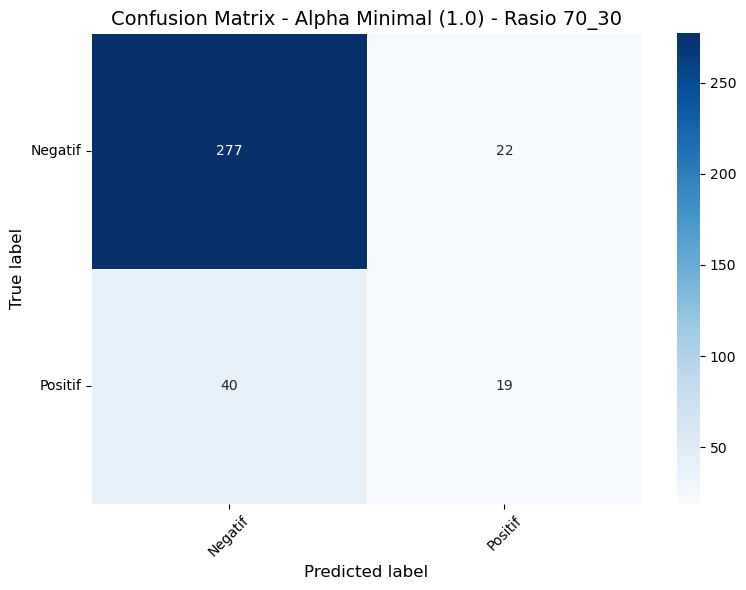

Metrik Evaluasi per Fold (Alpha Maksimal: 2.0):


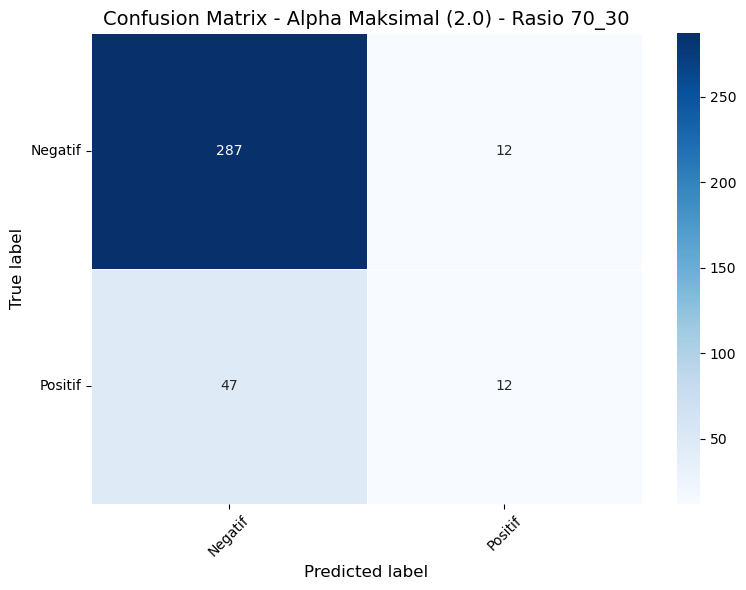

--------------------------------------------------------------------------------

=== Confusion Matrix untuk Rasio Data 80_20 ===

Metrik Evaluasi per Fold (Alpha Minimal: 1.0):


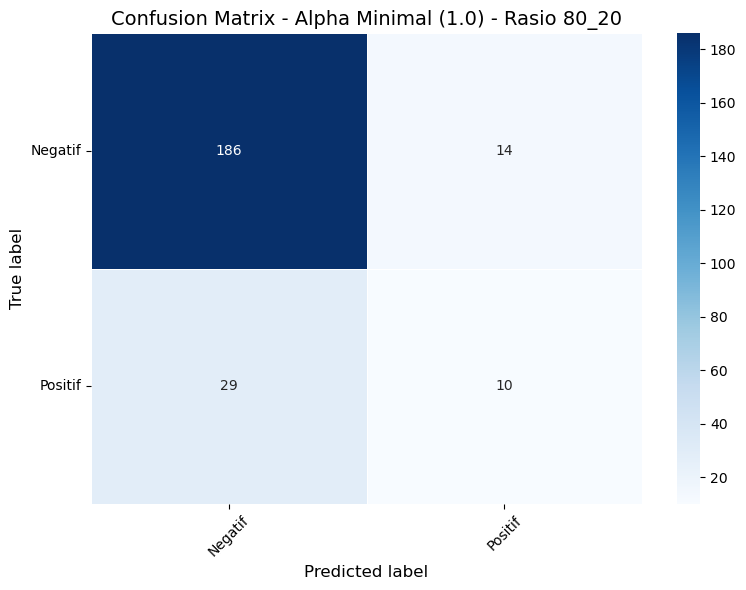

Metrik Evaluasi per Fold (Alpha Maksimal: 2.0):


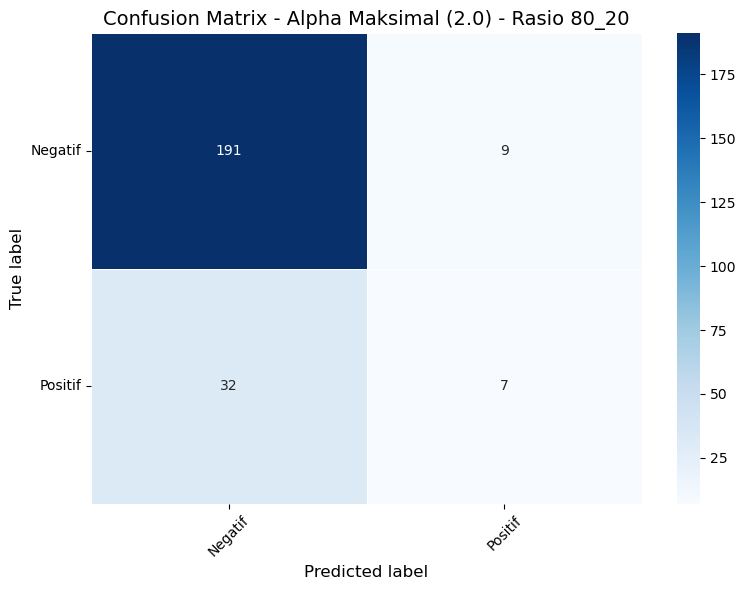

--------------------------------------------------------------------------------

=== Confusion Matrix untuk Rasio Data 90_10 ===

Metrik Evaluasi per Fold (Alpha Minimal: 0.01):


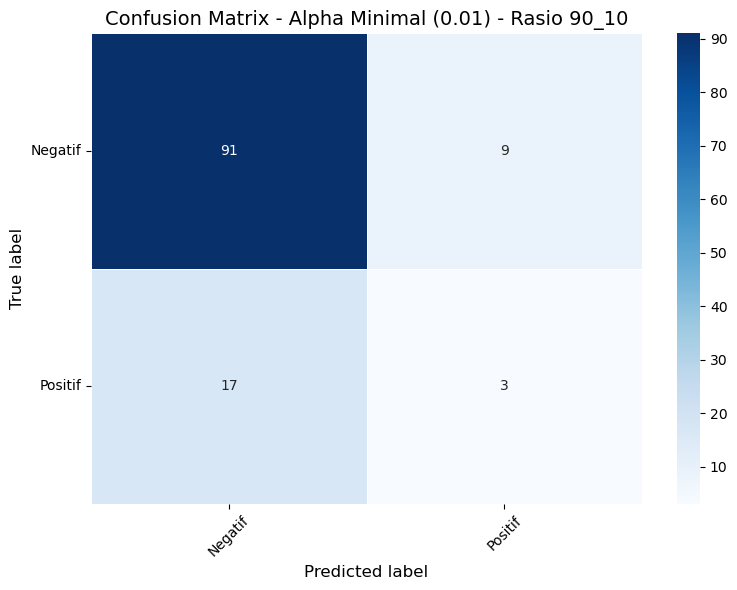

Metrik Evaluasi per Fold (Alpha Maksimal: 2.0):


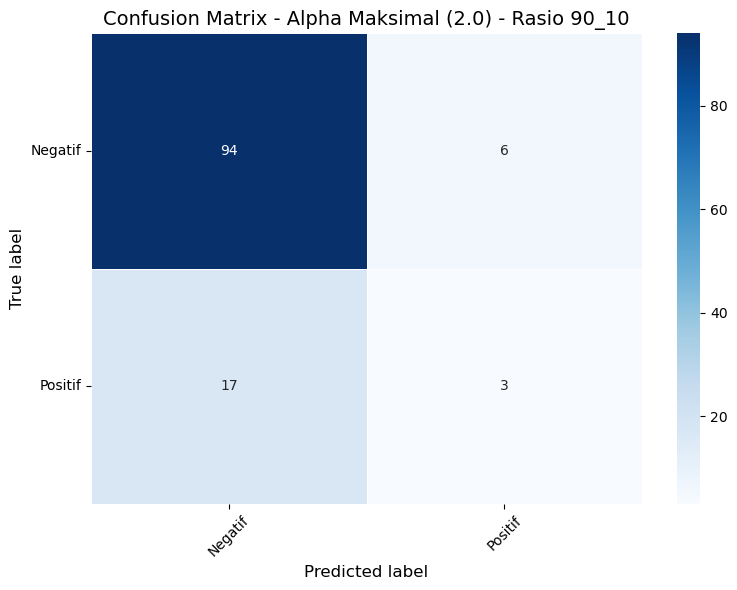

--------------------------------------------------------------------------------



In [13]:
# Membuat list untuk menyimpan hasil
accuracy_results = []

for ratio in split_ratios:
    print(f"=== Confusion Matrix untuk Rasio Data {ratio} ===\n")
    
    for tuning_type, alphas in tuning_configs.items():
        # Menentukan alpha terbaik
        best_alpha = find_best_alpha(ratio, tuning_type, alphas, csv_dir)
        
        if best_alpha is not None:
            print(f"Metrik Evaluasi per Fold (Alpha {'Minimal' if tuning_type=='minimal' else 'Maksimal'}: {best_alpha}):")
            
            try:
                # Memuat model terbaik yang telah dilatih sebelumnya
                model_pkl = f'mnb_alpha_{best_alpha}_tuning_{tuning_type}_ratio_{ratio}.pkl'
                model_path = os.path.join(pickle_dir, model_pkl)
                if os.path.exists(model_path):
                    with open(model_path, 'rb') as f:
                        model = pickle.load(f)
                else:
                    print(f'Error: Model {model_pkl} tidak ditemukan.\n')
                    continue
                
                # Memuat data test
                test_csv_path = f'test_{ratio}.csv'
                test_df = pd.read_csv(os.path.join(csv_dir, test_csv_path))
                y_test = test_df['kelas'].values
                
                # Memuat Matriks Bag of Words untuk test set
                test_bow_pkl = f'test_bow_{ratio}.pkl'
                test_bow_path = os.path.join(pickle_dir, test_bow_pkl)
                if os.path.exists(test_bow_path):
                    with open(test_bow_path, 'rb') as f:
                        X_test_bow = pickle.load(f)
                else:
                    print(f'Error: File {test_bow_pkl} tidak ditemukan.\n')
                    continue
                
                # Melakukan prediksi
                y_pred = model.predict(X_test_bow)
                
                # Menampilkan Confusion Matrix
                plot_confusion_matrix(
                    y_test, y_pred, 
                    classes=model.classes_, 
                    title=f'Confusion Matrix - Alpha {"Minimal" if tuning_type=="minimal" else "Maksimal"} ({best_alpha}) - Rasio {ratio}'
                )
                
                # Menyimpan hasil untuk bar plot
                # Membaca rata-rata akurasi
                cv_mean_accuracy_csv = f'cv_mean_accuracy_alpha_{best_alpha}_tuning_{tuning_type}_ratio_{ratio}.csv'
                cv_mean_accuracy_path = os.path.join(csv_dir, cv_mean_accuracy_csv)
                if os.path.exists(cv_mean_accuracy_path):
                    df_mean = pd.read_csv(cv_mean_accuracy_path)
                    mean_accuracy = df_mean['mean_accuracy'].iloc[0]
                else:
                    mean_accuracy = None
                    print(f'Warning: {cv_mean_accuracy_csv} tidak ditemukan.')
                
                # Menyimpan hasil untuk bar plot
                if mean_accuracy is not None:
                    accuracy_results.append({
                        'ratio': ratio.replace('_', ':'),
                        'tuning_type': tuning_type.capitalize(),
                        'mean_accuracy': mean_accuracy
                    })
                
            except FileNotFoundError as fnf_error:
                print(f'Error: {fnf_error}\n')
            except Exception as e:
                print(f'Error saat melakukan K-Fold CV untuk rasio {ratio} dan alpha {best_alpha}: {e}\n')
        else:
            print(f'Tidak ditemukan alpha terbaik untuk rasio {ratio} dan tuning {tuning_type}.\n')
    
    print("-"*80 + "\n")


### 8.2 Bar Plot Akurasi

In [14]:
# Membuat DataFrame dari hasil yang dikumpulkan
accuracy_df = pd.DataFrame(accuracy_results)
accuracy_df


,ratio,tuning_type,mean_accuracy
0,70:30,Minimal,0.75
1,70:30,Maksimal,0.78
2,80:20,Minimal,0.77
3,80:20,Maksimal,0.80
4,90:10,Minimal,0.80
5,90:10,Maksimal,0.79


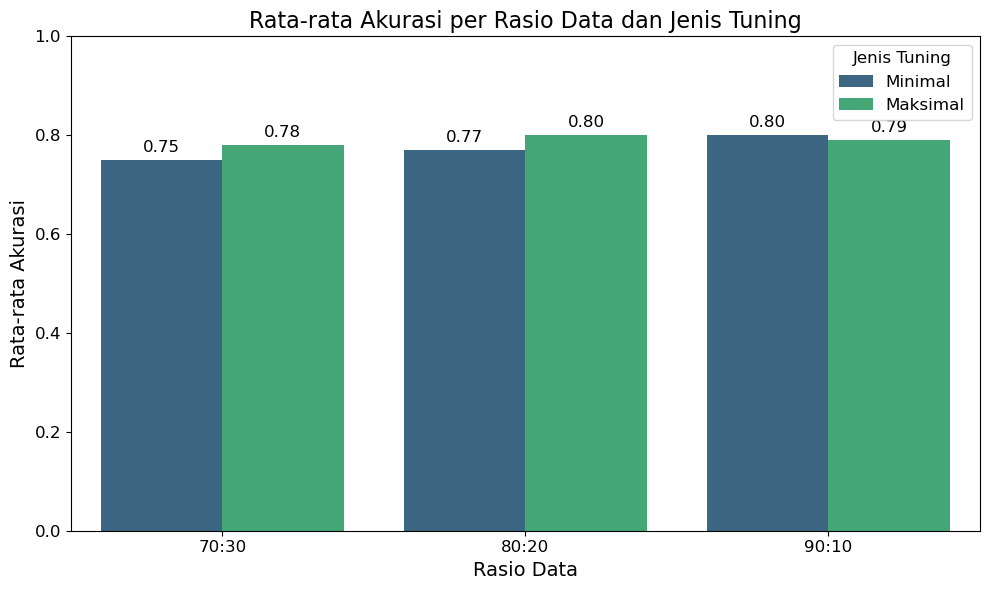

In [15]:
plt.figure(figsize=(10,6))
sns.barplot(x='ratio', y='mean_accuracy', hue='tuning_type', data=accuracy_df, palette='viridis')

plt.title('Rata-rata Akurasi per Rasio Data dan Jenis Tuning', fontsize=16)
plt.ylabel('Rata-rata Akurasi', fontsize=14)
plt.xlabel('Rasio Data', fontsize=14)
plt.ylim(0,1)  # Menyesuaikan skala y-axis antara 0 dan 1
plt.legend(title='Jenis Tuning', fontsize=12, title_fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Menambahkan label nilai di atas setiap bar
for index, row in accuracy_df.iterrows():
    plt.text(x=index//2 + (index%2)*0.4 - 0.2,  # Menyesuaikan posisi teks
             y=row['mean_accuracy'] + 0.01, 
             s=f"{row['mean_accuracy']:.2f}", 
             ha='center', 
             va='bottom', 
             fontsize=12, 
             color='black')

plt.tight_layout()
plt.show()
